In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import zipfile
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
import os
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D




# Reading data from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.listdir('/content/drive/MyDrive/data.zip')

['data.zip']

In [ ]:
import zipfile

zip_file_path = '/content/drive/MyDrive/data.zip/data.zip'
# Define the extraction directory
extracted_dir = '/content/drive/MyDrive/data.zip'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# Verify the contents of the extracted folder
os.listdir(extracted_dir)


['data.zip', 'GalaxyMorphology']

In [ ]:
import os

base_dir = '/content/drive/MyDrive/data.zip/GalaxyMorphology/data'

# List files to check if it's mounted correctly
os.listdir(base_dir)


['test', 'validation', 'train']

In [ ]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
testing_dir = os.path.join(base_dir, 'test')

In [ ]:
os.listdir(train_dir)

['spiral', 'lenticular', 'elliptical']

In [ ]:
os.listdir(validation_dir)

['spiral', 'lenticular', 'elliptical']

In [ ]:
os.listdir(testing_dir)

['elliptical', 'spiral', 'lenticular']

# Data PreProcessing

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,


validation_datagen = ImageDataGenerator(rescale=1./255)


**For Train and Validation**

In [ ]:
# Create the training and validation data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 6833 images belonging to 3 classes.
Found 3450 images belonging to 3 classes.


# Batch of Images

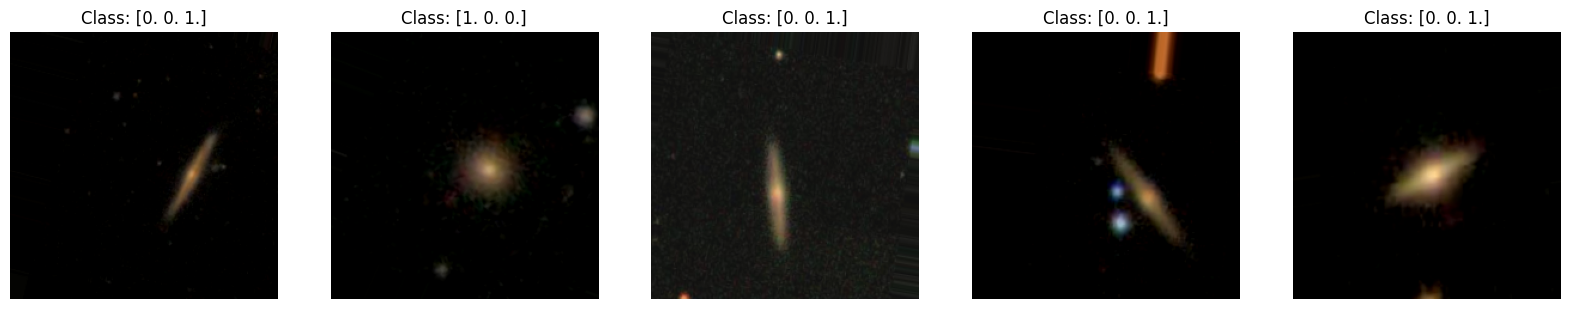

In [ ]:
# Show a batch of images
images, labels = next(train_generator)
fig, axes = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    ax = axes[i]
    ax.imshow(images[i])
    ax.axis('off')
    ax.set_title(f'Class: {labels[i]}')
plt.show()


# Number of Images

In [ ]:
# Check the number of images in each class in the training dataset
class_counts_train = train_generator.class_indices
class_counts_val = validation_generator.class_indices

print("Class Counts in Training Dataset:")
for class_name, index in class_counts_train.items():
    print(f'{class_name}: {sum(train_generator.classes == index)} images')

print("\nClass Counts in Validation Dataset:")
for class_name, index in class_counts_val.items():
    print(f'{class_name}: {sum(validation_generator.classes == index)} images')


Class Counts in Training Dataset:
elliptical: 2375 images
lenticular: 2447 images
spiral: 2011 images

Class Counts in Validation Dataset:
elliptical: 1367 images
lenticular: 1159 images
spiral: 924 images


In [ ]:
# Check the number of images in each class in the training dataset
class_counts_train = train_generator.class_indices
class_counts_val = validation_generator.class_indices

print("Class Counts in Training Dataset:")
for class_name, index in class_counts_train.items():
    print(f'{class_name}: {sum(train_generator.classes == index)} images')

print("\nClass Counts in Validation Dataset:")
for class_name, index in class_counts_val.items():
    print(f'{class_name}: {sum(validation_generator.classes == index)} images')


Class Counts in Training Dataset:
elliptical: 2375 images
lenticular: 2447 images
spiral: 2011 images

Class Counts in Validation Dataset:
elliptical: 1367 images
lenticular: 1159 images
spiral: 924 images


In [ ]:
print(f"Total samples in training set: {train_generator.samples}")
print(f"Total samples in validation set: {validation_generator.samples}")


Total samples in training set: 6833
Total samples in validation set: 3450


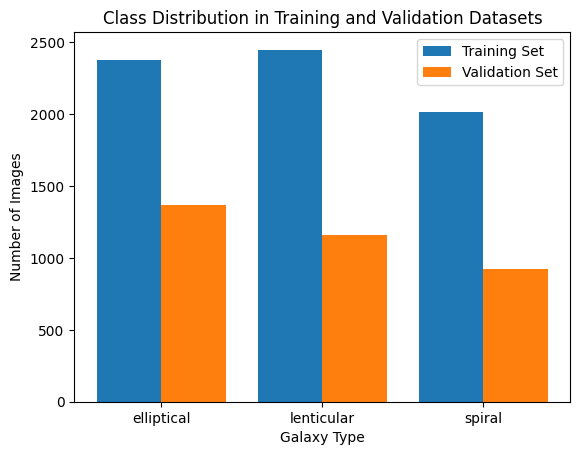

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the number of samples per class
train_class_counts = [sum(train_generator.classes == i) for i in range(len(train_generator.class_indices))]
val_class_counts = [sum(validation_generator.classes == i) for i in range(len(validation_generator.class_indices))]

# Plotting the distribution
labels = list(train_generator.class_indices.keys())
x = np.arange(len(labels))

plt.bar(x - 0.2, train_class_counts, 0.4, label='Training Set')
plt.bar(x + 0.2, val_class_counts, 0.4, label='Validation Set')

plt.xticks(x, labels)
plt.xlabel('Galaxy Type')
plt.ylabel('Number of Images')
plt.legend()
plt.title('Class Distribution in Training and Validation Datasets')
plt.show()


##Model Architecture

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

def create_cnn_model(input_shape=(224, 224, 3), num_classes=3):
    model = Sequential()

    # First Conv Layer
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Conv Layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third Conv Layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fourth Conv Layer (optional, for better feature extraction)
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Global Average Pooling (to reduce dimensionality)
    model.add(GlobalAveragePooling2D())

    # Dropout layer
    model.add(Dropout(0.5))

    # Dense Layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    return model


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Create the CNN model
model = create_cnn_model(input_shape=(224, 224, 3), num_classes=3)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,  # Wait 5 epochs for improvement
                               restore_best_weights=True)  # Restore the model with the best weights

# Reduce learning rate on plateau for better convergence
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=3,  # Wait 3 epochs for no improvement
                                 factor=0.5,  # Reduce LR by a factor of 0.5
                                 min_lr=0.0001)  # Minimum LR to avoid excessively small values




/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 423,619 (1.62 MB)

 Trainable params: 422,659 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Fit the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, lr_reduction]  # Include both callbacks
)

Epoch 1/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 170s 721ms/step - accuracy: 0.3816 - loss: 1.3541 - val_accuracy: 0.2678 - val_loss: 1.2331 - learning_rate: 0.0010
Epoch 2/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 183s 666ms/step - accuracy: 0.5155 - loss: 0.8995 - val_accuracy: 0.2684 - val_loss: 2.2150 - learning_rate: 0.0010
Epoch 3/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 145s 661ms/step - accuracy: 0.5743 - loss: 0.7842 - val_accuracy: 0.4643 - val_loss: 0.9819 - learning_rate: 0.0010
Epoch 4/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 145s 661ms/step - accuracy: 0.5951 - loss: 0.7194 - val_accuracy: 0.2936 - val_loss: 2.0462 - learning_rate: 0.0010
Epoch 5/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 204s 662ms/step - accuracy: 0.6138 - loss: 0.6812 - val_accuracy: 0.5614 - val_loss: 0.7345 - learning_rate: 0.0010
Epoch 6/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 202s 666ms/step - accuracy: 0.6341 - loss: 0.6519 - val_accuracy: 0.6501 - val_loss: 0.6081 - learning_rate: 0.0010
Epoch 7/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 143s 652ms/step - accura

In [ ]:
model.save('galaxy_morphology_model.h5')  # Save the model to a file


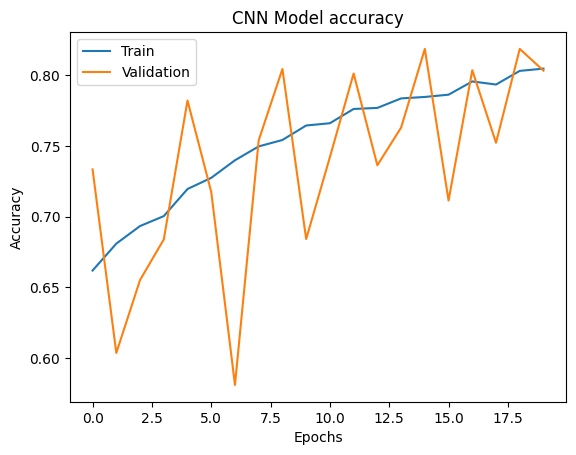

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


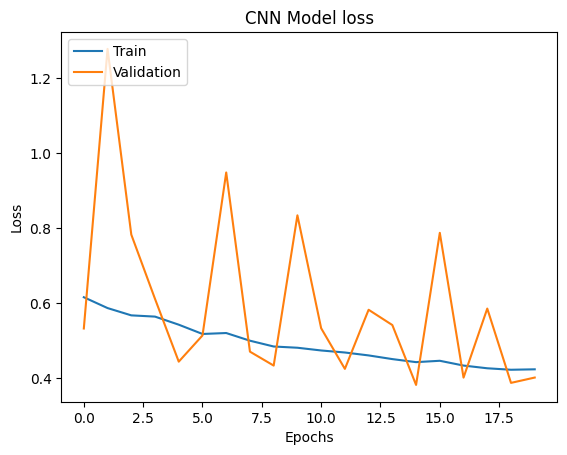

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Testing

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)  # Apply the same rescaling

test_generator = test_datagen.flow_from_directory(
    testing_dir,  # Path to test data
    target_size=(224, 224),    # Same target size used during training
    batch_size=32,
    class_mode='categorical'   # Or 'binary' if you have two classes
)


Found 442 images belonging to 3 classes.


In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.8238 - loss: 0.3789
Test Loss: 0.38762757182121277
Test Accuracy: 0.8167420625686646


**Visualize Results**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


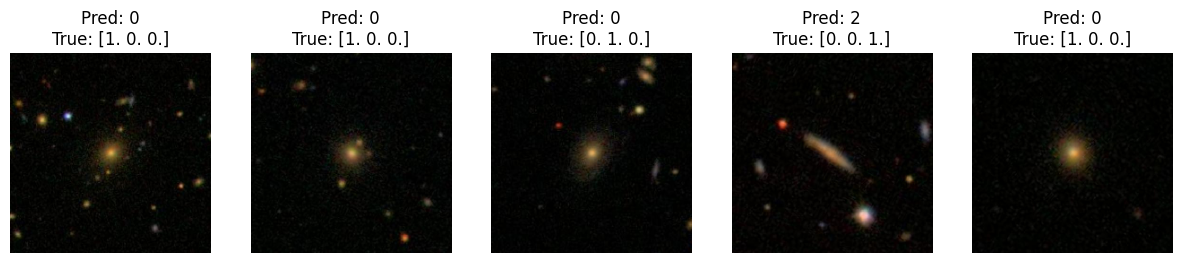

In [ ]:
import matplotlib.pyplot as plt

# Select a random batch from the test generator
images, labels = next(test_generator)

# Predict on this batch
predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)

# Plot images with their predicted and true labels
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    ax = axes[i]
    ax.imshow(images[i])
    ax.set_title(f"Pred: {predicted_classes[i]}\nTrue: {labels[i]}")
    ax.axis('off')

plt.show()


# Transfer learning on ResNet50

In [ ]:
num_classes = 3
input_shape = (224, 224, 3)

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
base_model.trainable = False  # later fine-tuning


In [ ]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Global Average Pooling
    layers.Dense(256, activation='tanh'),  # Add custom dense layers for learning
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',  # Because it's a multi-class classification problem
    metrics=['accuracy']
)


In [ ]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,113,027 (91.98 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
validation_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Replace with your actual training data path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,  # Replace with your actual validation data path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 6833 images belonging to 3 classes.
Found 3450 images belonging to 3 classes.


**After 10 epochs accuracy still under 40% So there is no need to Complete. **

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


214/214 ━━━━━━━━━━━━━━━━━━━━ 173s 732ms/step - accuracy: 0.3501 - loss: 1.2118 - val_accuracy: 0.3359 - val_loss: 1.0955
Epoch 2/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 166s 595ms/step - accuracy: 0.3411 - loss: 1.0965 - val_accuracy: 0.3359 - val_loss: 1.0915
Epoch 3/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 144s 604ms/step - accuracy: 0.3588 - loss: 1.0955 - val_accuracy: 0.3359 - val_loss: 1.0910
Epoch 4/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 132s 605ms/step - accuracy: 0.3700 - loss: 1.0924 - val_accuracy: 0.3359 - val_loss: 1.0925
Epoch 5/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 126s 577ms/step - accuracy: 0.3495 - loss: 1.0949 - val_accuracy: 0.3359 - val_loss: 1.0917
Epoch 6/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 146s 597ms/step - accuracy: 0.3637 - loss: 1.0949 - val_accuracy: 0.3359 - val_loss: 1.0914
Epoch 7/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 134s 613ms/step - accuracy: 0.3536 - loss: 1.0960 - val_accuracy: 0.3359 - val_loss: 1.0912
Epoch 8/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 133s 600ms/step - accuracy: 0.3666 - loss: 1.09

In [ ]:
base_model.trainable = True
fine_tune_at = 100  # Unfreeze layers from a certain point in ResNet50

# Freeze the layers before the fine-tune point
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model after unfreezing
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# Continue training with fine-tuning
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 128s 579ms/step - accuracy: 0.6553 - loss: 0.6304 - val_accuracy: 0.7333 - val_loss: 0.5326
Epoch 2/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 127s 580ms/step - accuracy: 0.6772 - loss: 0.5830 - val_accuracy: 0.6035 - val_loss: 1.2783
Epoch 3/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 126s 573ms/step - accuracy: 0.7028 - loss: 0.5569 - val_accuracy: 0.6551 - val_loss: 0.7831
Epoch 4/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 128s 582ms/step - accuracy: 0.7004 - loss: 0.5601 - val_accuracy: 0.6838 - val_loss: 0.6115
Epoch 5/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 126s 576ms/step - accuracy: 0.7206 - loss: 0.5298 - val_accuracy: 0.7820 - val_loss: 0.4441
Epoch 6/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 132s 601ms/step - accuracy: 0.7293 - loss: 0.5142 - val_accuracy: 0.7174 - val_loss: 0.5140
Epoch 7/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 140s 594ms/step - accuracy: 0.7347 - loss: 0.5245 - val_accuracy: 0.5809 - val_loss: 0.9487
Epoch 8/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 128s 582ms/step - accuracy: 0.7431 -

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)  # Apply the same rescaling

In [ ]:
test_generator = test_datagen.flow_from_directory(
    testing_dir,  # Path to your test data
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Found 442 images belonging to 3 classes.
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8204 - loss: 0.3665
Test Loss: 0.3666914999485016
Test Accuracy: 0.8235294222831726


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step


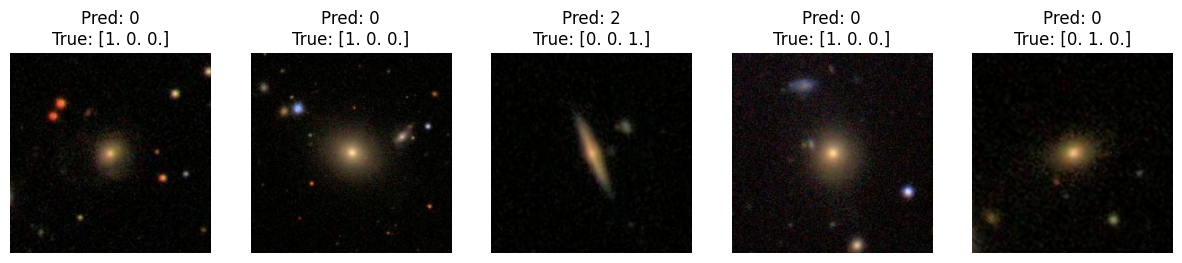

In [ ]:
import matplotlib.pyplot as plt

# Select a random batch from the test generator
images, labels = next(test_generator)

# Predict on this batch
predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)

# Plot images with their predicted and true labels
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    ax = axes[i]
    ax.imshow(images[i])
    ax.set_title(f"Pred: {predicted_classes[i]}\nTrue: {labels[i]}")
    ax.axis('off')

plt.show()
